# Tutorial: Transfer learning with a reference PBMC model

This tutorial demonstrates how to train a reference HD-AE model and then use that model to embed new datasets not seen during training. In this tutorial we'll be considering a set of peripheral blood mononuclear cell (PBMC) data in nine batches using seven different technologies.

---

## Tutorial Goals:

The following is walkthrough of how to use `HD-AE` for transfer learning tasks. Our goals here are:

1. Train a reference HD-AE embedding model that learns a low-dimensional embedding space in which cells group by meaningful biological variations rather than nuisance factors (e.g. scRNA-seq technology)
2. Use this reference model to embed new, previously unseen datasets

---

## The data:

Our data consists of 30,975 cells, the expression levels of which were measured using seven different scRNA-seq technologies in nine batches. For convenience we provide a preprocessed version of the data available for download <a href="https://www.dropbox.com/s/bck6kksx34fbalh/pbmc.h5ad?dl=0">here</a> that has already been filtered down to the 2000 most variable genes and has been normalized using the <a href="https://satijalab.org/seurat/">Seurat R package</a>. The `HD-AE` codebase was designed for use with the <a href="https://scanpy.readthedocs.io/en/stable/">scanpy</a> Python package, which we will use here to read in and visualize our data.

First, we'll verify that the data has batch effects using the UMAP dimensionality reduction algorithm. Our provided dataset has been annotated with the technology used to collect it as well as ground-truth cell types, making it easy to confirm the presence of batch effects. 

         Falling back to preprocessing with `sc.pp.pca` and default params.


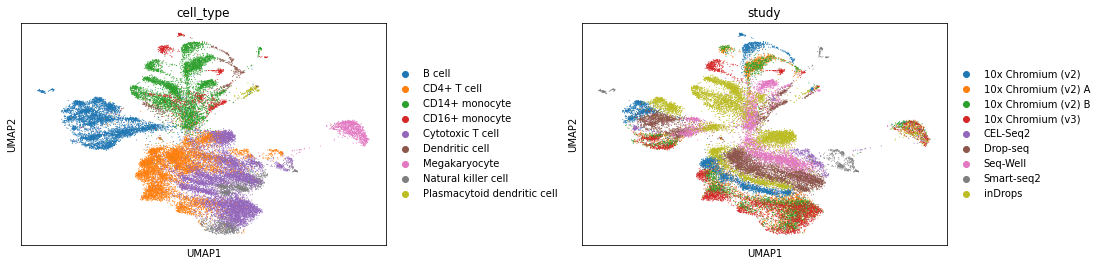

In [1]:
import scanpy as sc
from hd_ae.utils import set_seeds

set_seeds() # To ensure reproducibility
adata = sc.read("pbmc.h5ad") # Make sure to download the data first from the link above! :)

sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['cell_type', 'study'], wspace=0.4)

In this tutorial, we'll be training our model using a subset of this data. We'll use seven of the nine batches (`source_adata`)for training our model, and hold out two of them (`target_adata`) for evaluation of our model's transfer learning capabilities.

In [2]:
target_batches = ["Drop-seq", "10x Chromium (v3)"]

source_adata = adata[~adata.obs['study'].isin(target_batches)]
target_adata = adata[adata.obs['study'].isin(target_batches)]

/homes/gws/ewein/miniconda3/envs/HD-AE/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


## HD-AE setup:

The low-level details of HD-AE have been abstracted away into a single `HD_AE` class that performs model training with just a few API calls. The `HD_AE` class requires at initialization time an AnnData object along with the name of the field used to denote each sample's batch of origin in the `obs` field of your AnnData object (`batch_key`). The values of HD-AE's hyperparameters can also be set here. We do them explicitly in this tutorial to illustrate the process, though these fields can also be left blank to use a reasonable default set of hyperparameters.

In [3]:
from hd_ae import HD_AE

hd_ae = HD_AE(
    source_adata,
    batch_key='study',
    hidden_layer_sizes=[500, 250],
    learning_rate = 1e-3,
    embedding_dimension=50,
    hsic_penalty = 1
)

## Training the model:

Once defined, the model can be trained with a single call to the `train` function. On a GPU-enabled machine, this should take <5 minutes.

In [4]:
hd_ae.train(num_epochs=100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 1.1 M 
1 | decoder   | Sequential | 1.1 M 
2 | criterion | MSELoss    | 0     
-----------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.121     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/166 [00:00<?, ?it/s] 

/homes/gws/ewein/miniconda3/envs/HD-AE/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 99: 100%|██████████| 166/166 [00:02<00:00, 61.28it/s, loss=0.133, v_num=10, reconstruction_loss=0.134, HSIC_loss=0.00112] 


Once trained, the HD-AE model can be used to produce integrated sets of low-dimensional embeddings.

In [5]:
source_embeddings = hd_ae.embed_data(source_adata)

Now we use UMAP plots to quickly verify that the embeddings of our training data are integrated across batches:

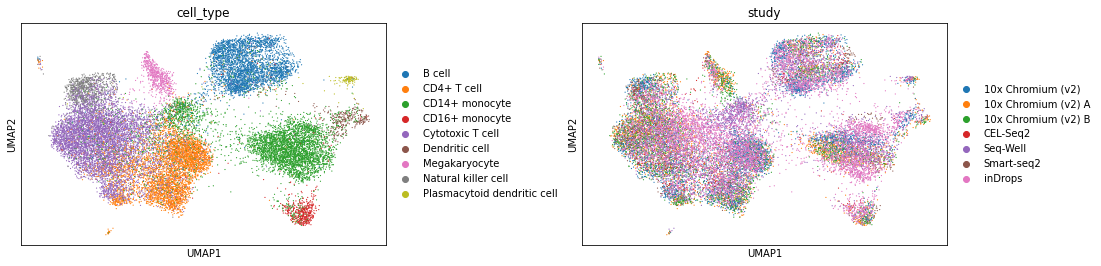

In [6]:
sc.pp.neighbors(source_embeddings)
sc.tl.umap(source_embeddings)
sc.pl.umap(source_embeddings, color=['cell_type', 'study'], wspace=0.4)

Based on our UMAP plots we can see that our training data clusters based on cell type and mixes across the different technologies.

---

Before we demonstrate HD-AE on a transfer learning task, we'll first save its parameters to disk. Doing so requires only a call to the `.save` function, along with the name of a directory to store the resulting files. Once saved, HD-AE models can be shared with other researchers for their own use.

In [7]:
hd_ae.save("pbmc_model", overwrite=True)

### Transfer learning with HD-AE

Now that we have a pretrained "reference" model, we can try embedding our target batches not seen during training. Ideally, we want the embeddings of our new test batches to still mix with the source batches provided by the model during training while still separating by cell type.

As a first step, we'll load our pretrained model.

In [8]:
loaded_model = HD_AE.load("pbmc_model")

Now we'll embed our test batches (in addition to the training batches for comparison)

... storing 'study' as categorical


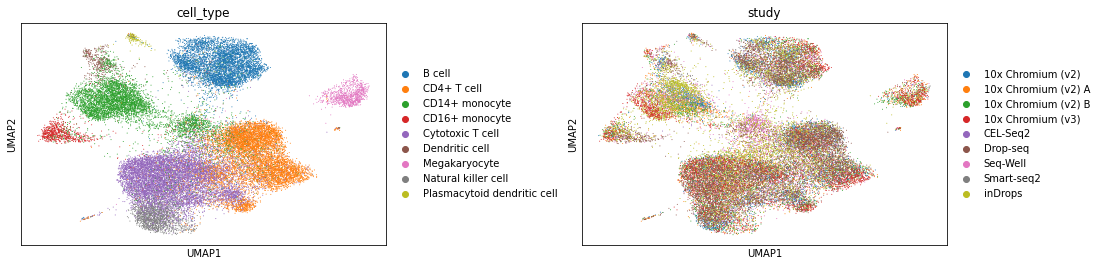

In [9]:
from anndata import concat

full_adata = concat([source_adata, target_adata])
full_embeddings = loaded_model.embed_data(full_adata)

sc.pp.neighbors(full_embeddings)
sc.tl.umap(full_embeddings)
sc.pl.umap(full_embeddings, color=['cell_type', 'study'], wspace=0.4)

From our UMAP plot we can see that our test batches do indeed mix with our source batches while separating by cell type!